In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"misbahjahan","key":"4d93143d069d176526de6e323748e535"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!cat ~/.kaggle/kaggle.json

{"username":"misbahjahan","key":"4d93143d069d176526de6e323748e535"}

In [6]:
# example
!kaggle datasets download -d puneet6060/intel-image-classification

 98% 341M/346M [00:01<00:00, 260MB/s]
100% 346M/346M [00:01<00:00, 239MB/s]


In [7]:
#unzip dataset in colab session
!unzip -q intel-image-classification.zip # -q for quiet

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# copy zipped dataset into your drive
!cp "intel-image-classification.zip" /content/drive/MyDrive/ML_A3

In [10]:
import numpy as np #//This line imports the NumPy library, which is commonly used for numerical operations in Python.
import pandas as pd #  data manipulation and analysis.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # working with images
import seaborn as sns #for statistical data visualization
import warnings
warnings.filterwarnings("ignore") # ignore unnecessary warnings
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import os # a way of interacting with the operating system, such as reading or writing files and directories.
from os import walk #The walk function generates file names in a directory tree by walking through the directory and its subdirectories recursively.
import tensorflow as tf
tf.random.set_seed(0) #This clears the TensorFlow session, releasing any resources held by the previous session. It's useful when you want to release memory after training or defining a model.
tf.keras.backend.clear_session() ##This clears the TensorFlow session, releasing any resources held by the previous session. It's useful when you want to release memory after training or defining a model.

In [11]:
classes = {"buildings":0,"forest":1,"glacier":2, "mountain":3, "sea":4, "street":5}
dir_train =  "/content/seg_train/seg_train"
dir_test = "/content/seg_test/seg_test"
dir_pred = "/content/seg_pred/seg_pred"

In [12]:
(dirpath_pred, dirnames_pred, fnames_pred) = next(walk(dir_pred))#current directory path, subdirectory, file names of prediction
print("Size of the prediction set is {}".format(len(fnames_pred)))

Size of the prediction set is 7301


In [21]:
def read_image_names_class(dpath):
    fnames = {}
    x, dirnames, y = next(walk(dpath))
    for d in dirnames:
        _,_,temp = next(walk(os.path.join(dpath,d)))
        fnames[classes[d]] = temp

    return dirnames, fnames

def check_class_imbalance(fnames):
    count = 0
    class_summary = {}
    for key,value in fnames.items():
        count = count + len(value)
        class_summary[key] = len(value)
    summary = pd.DataFrame.from_dict(class_summary, orient='index', columns=["Count"])
    summary['CumCount'] = np.cumsum(summary['Count'])
    summary['Class'] = summary.index
    summary['Class'] = summary['Class'].apply(class_from_key)

    return summary

def class_from_key(x):
    for key, value in classes.items():
        if x == value:
            return key

def sample_images_from_class(nsample, classname, path, fnames):
    sind = np.random.random_integers(1,len(fnames[classes[classname]]),nsample)
    spath = [os.path.join(path, classname, fnames[classes[classname]][i]) for i in sind]

    return spath

def plot_sampled_images(path, fnames):
    nsample = 3
    ncols = len(classes)

    fig, ax = plt.subplots(nsample, ncols, figsize=(20, 3*nsample))

    for i,cl in enumerate(classes.keys()):
        sp = sample_images_from_class(nsample, cl, path, fnames)
        for j,spj in enumerate(sp):
            img = mpimg.imread(spj)
            ax[j,i].imshow(img)
            ax[j,i].axis('off')
            ax[j,i].set_title(cl)

def sample_prediction_images(path, fnames, nsample):
    sind = np.random.random_integers(1,len(fnames), nsample)
    spj = []
    for sp in sind:

                spj.append(os.path.join(path, fnames[sp]))

    return spj

def plot_sampled_prediction_images(path, fnames):
    nsample = 3
    ncols = len(classes)

    fig, ax = plt.subplots(nsample, ncols, figsize=(20, 3*nsample))
    sind = np.random.random_integers(1,len(fnames), nsample*ncols)

    axs = ax.ravel()
    for i, sp in enumerate(sind):
        spj = os.path.join(path, fnames[sp])
        img = mpimg.imread(spj)
        axs[i].imshow(img)
        axs[i].axis('off')

def get_true_pred(model, ds):
    y = model.predict(ds)

    ytrue = []
    ypred = []

    ypred.append(np.argmax(y,axis=1))
    for img, lbl in ds:
        for l in lbl:
            ytrue.append(np.argmax(l.numpy()))
    return ytrue, ypred

def plot_confMat(ytrue, ypred):
    cm = confusion_matrix(y_true = ytrue,y_pred = ypred[0])
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_from_key(x) for x in range(6)])
    fig,ax = plt.subplots(1,1,figsize=(8,8))
    cmd.plot(include_values=True, cmap = plt.cm.Blues, ax=ax)

    plt.title("Accuracy score is {:.2f}".format(accuracy_score(y_true = ytrue,y_pred = ypred[0])))

def read_prepare_image_predict(fpath, mod):
    img = tf.keras.preprocessing.image.load_img(fpath, grayscale=False, color_mode='rgb')
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
    ax1.imshow(img)
    ax1.axis('off')

    parr = tf.keras.preprocessing.image.img_to_array(img)
    tparr = tf.expand_dims(parr, axis=0)

    pred = mod.predict(tparr)
    y = [p for p in pred[0]]
    x = [class_from_key(i) for i in range(6)]

    sns.barplot(x=x,y=y,ax=ax2)

    return pred

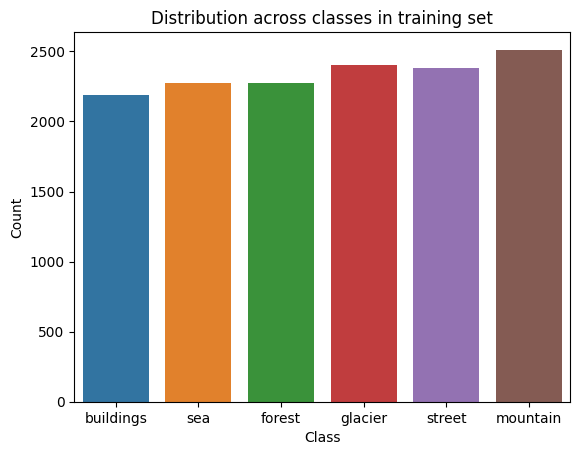

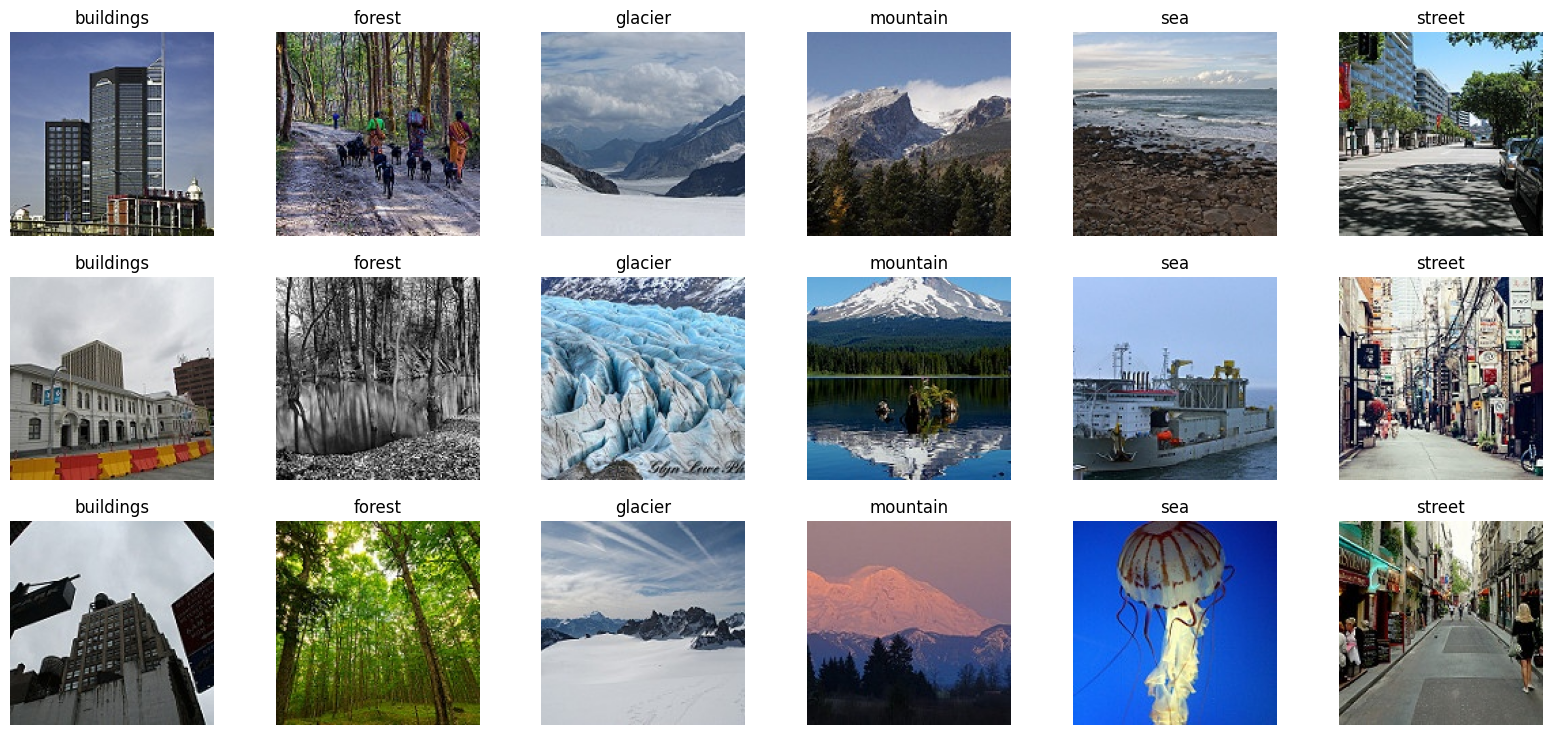

In [22]:
dirnames_train, fnames_train = read_image_names_class(dir_train)
train_summary = check_class_imbalance(fnames_train)
train_summary.head(10)
sns.barplot(data=train_summary, x = 'Class', y='Count').set_title("Distribution across classes in training set")
plot_sampled_images(dir_train, fnames_train)

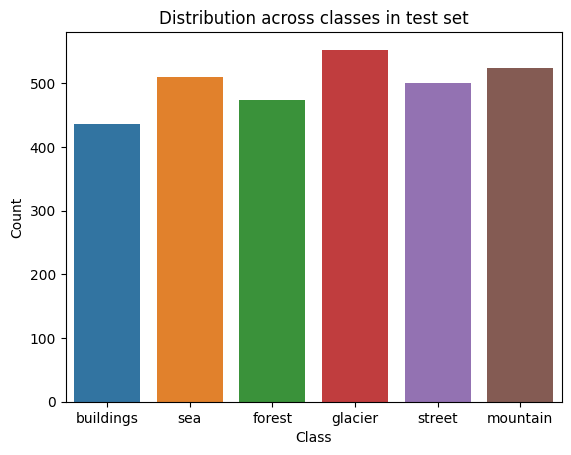

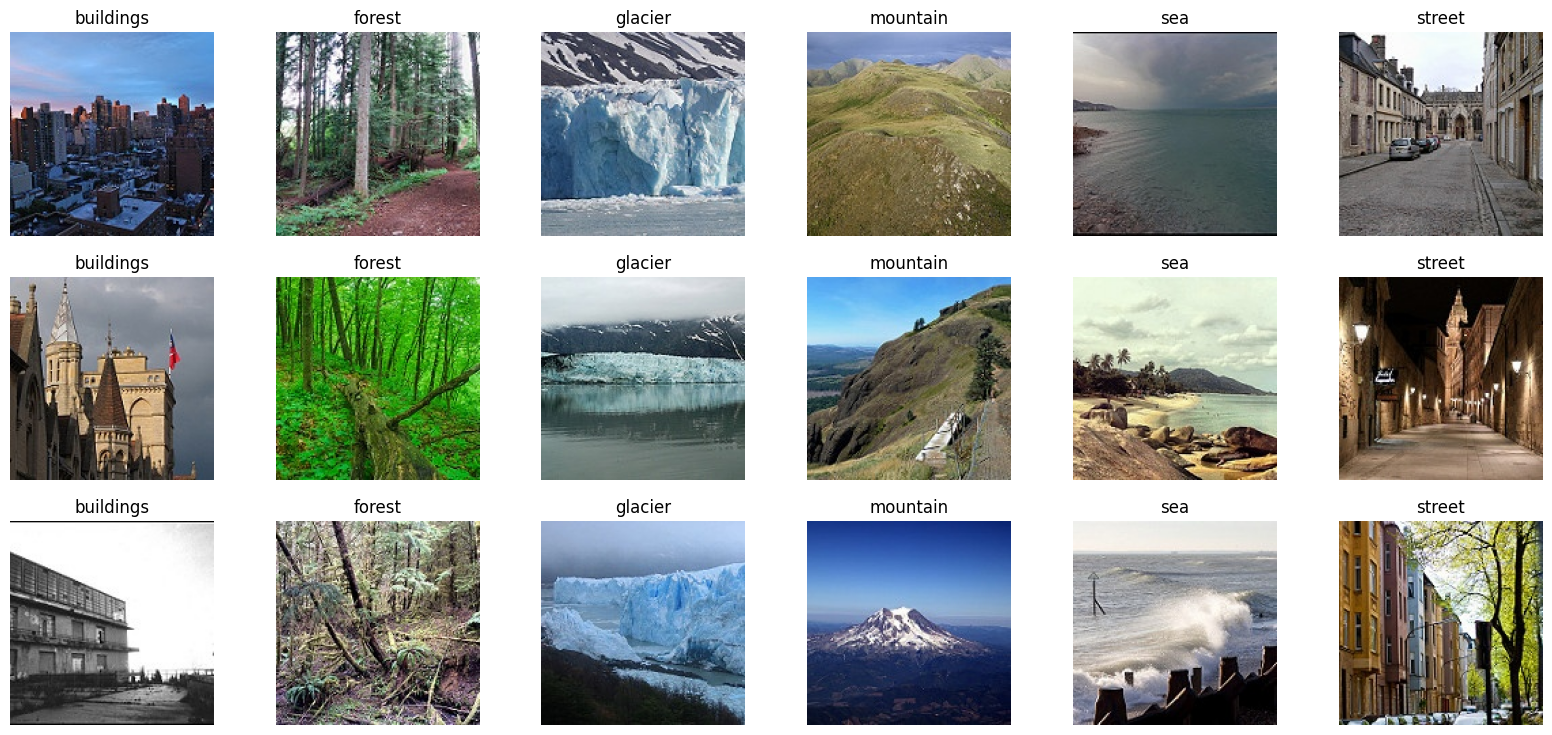

In [23]:
dirnames_test, fnames_test = read_image_names_class(dir_test)
test_summary = check_class_imbalance(fnames_test)
test_summary.head(10)

sns.barplot(data=test_summary, x = 'Class', y='Count').set_title("Distribution across classes in test set")

plot_sampled_images(dir_test, fnames_test)

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [25]:
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    "/content/seg_train/seg_train",
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    "/content/seg_test/seg_test",
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add more layers as needed

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=6, activation='softmax'))

In [27]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/5
439/439 [==============================] - 550s 1s/step - loss: 1.3261 - accuracy: 0.6030 - val_loss: 0.8917 - val_accuracy: 0.6947
Epoch 2/5
439/439 [==============================] - 514s 1s/step - loss: 0.7958 - accuracy: 0.7150 - val_loss: 0.7504 - val_accuracy: 0.7497
Epoch 3/5
439/439 [==============================] - 541s 1s/step - loss: 0.7319 - accuracy: 0.7379 - val_loss: 0.7119 - val_accuracy: 0.7487
Epoch 4/5
439/439 [==============================] - 516s 1s/step - loss: 0.6738 - accuracy: 0.7560 - val_loss: 0.9782 - val_accuracy: 0.6720
Epoch 5/5
439/439 [==============================] - 532s 1s/step - loss: 0.6365 - accuracy: 0.7712 - val_loss: 0.8112 - val_accuracy: 0.7437


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 128)               22429824  
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 22431494 (85.57 MB)
Trainable params: 22431494 (85.57 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [29]:
test_generator = test_datagen.flow_from_directory(
    "/content/seg_test/seg_test",
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy: {test_acc}')

Found 3000 images belonging to 6 classes.
94/94 [==============================] - 33s 345ms/step - loss: 0.8112 - accuracy: 0.7437
Test accuracy: 0.7436666488647461


In [31]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions for the test set
test_predictions = model.predict(test_generator)
test_pred_classes = np.argmax(test_predictions, axis=1)
test_true_classes = test_generator.classes

# Display the confusion matrix
conf_mat = confusion_matrix(test_true_classes, test_pred_classes)
print("Confusion Matrix:")
print(conf_mat)
from sklearn.metrics import classification_report

# Display classification report
class_labels = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(test_true_classes, test_pred_classes, target_names=class_labels))

94/94 [==============================] - 23s 243ms/step - loss: 0.8112 - accuracy: 0.7437
Test Accuracy: 74.37%
Test Loss: 0.8112
94/94 [==============================] - 22s 239ms/step
Confusion Matrix:
[[338  32   5   2  10  50]
 [  3 465   0   1   1   4]
 [ 29  13 409  43  48  11]
 [ 45  17  78 319  61   5]
 [ 48  14  72  25 343   8]
 [ 54  80   4   2   4 357]]
Classification Report:
              precision    recall  f1-score   support

   buildings       0.65      0.77      0.71       437
      forest       0.75      0.98      0.85       474
     glacier       0.72      0.74      0.73       553
    mountain       0.81      0.61      0.70       525
         sea       0.73      0.67      0.70       510
      street       0.82      0.71      0.76       501

    accuracy                           0.74      3000
   macro avg       0.75      0.75      0.74      3000
weighted avg       0.75      0.74      0.74      3000



Found 14034 files belonging to 6 classes.
439/439 [==============================] - 99s 225ms/step - loss: 183.9762 - accuracy: 0.6930


[183.9761962890625, 0.6929599642753601]

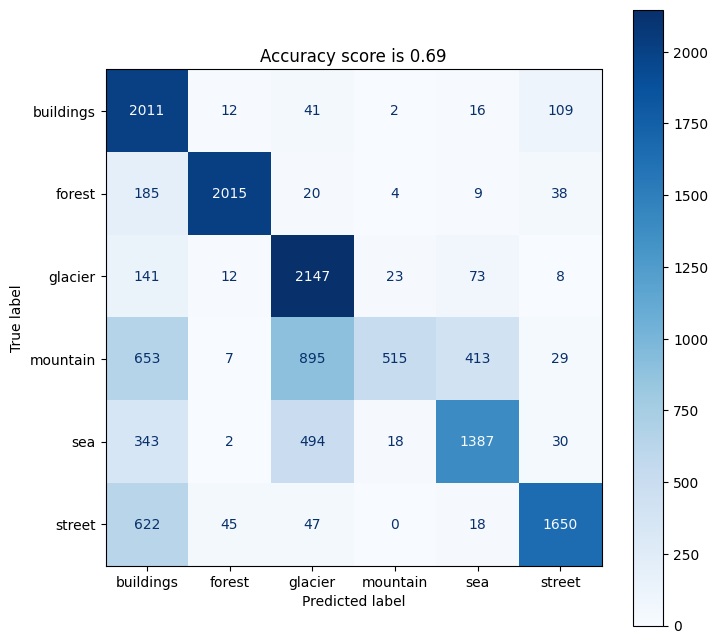

In [32]:
train_ds1 = tf.keras.preprocessing.image_dataset_from_directory(dir_train,
                                                               seed=0,  image_size=(150, 150),
                                                               batch_size=batch_size, shuffle= False, label_mode='categorical')
y_true, y_pred = get_true_pred(model, train_ds1)
plot_confMat(y_true, y_pred)

model.evaluate(train_ds1)

Found 3000 files belonging to 6 classes.
94/94 [==============================] - 23s 247ms/step - loss: 223.3410 - accuracy: 0.6607


[223.3410186767578, 0.6606666445732117]

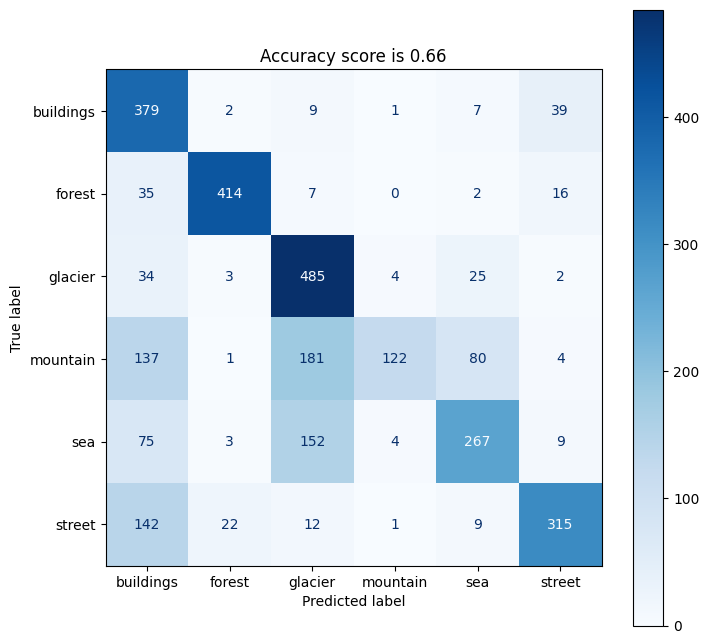

In [33]:
test_ds1 = tf.keras.preprocessing.image_dataset_from_directory(dir_test, seed=0,  image_size=(150, 150),
                                                               batch_size=batch_size, shuffle= False, label_mode='categorical')
# y_test = mod.predict(test_ds)
# tf.keras.utils.to_categorical(np.argmax(y_test,axis=1))
y_true, y_pred = get_true_pred(model, test_ds1)
plot_confMat(y_true, y_pred)

model.evaluate(test_ds1)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Epoch 1/10
351/351 [==============================] - 363s 1s/step - loss: 23.5650 - accuracy: 0.4770 - val_loss: 1.9338 - val_accuracy: 0.1707
Epoch 2/10
351/351 [==============================] - 348s 991ms/step - loss: 1.8340 - accuracy: 0.1979 - val_loss: 1.9122 - val_accuracy: 0.2163
Epoch 3/10
351/351 [==============================] - 358s 1s/step - loss: 1.7289 - accuracy: 0.2362 - val_loss: 1.7488 - val_accuracy: 0.2153
Epoch 4/10
351/351 [==============================] - 342s 971ms/step - loss: 1.7081 - accuracy: 0.2324 - val_loss: 1.7726 - val_accuracy: 0.1964
Epoch 5/10
351/351 [==============================] - 354s 1s/step - loss: 1.7533 - accuracy: 0.2054 - val_loss: 1.7786 - val_accuracy: 0.1796
Epoch 6/10
351/351 [==============================] - 355s 1s/step - loss: 1.7675 - accuracy: 0.2077 - val_loss: 1.8575 - val_acc

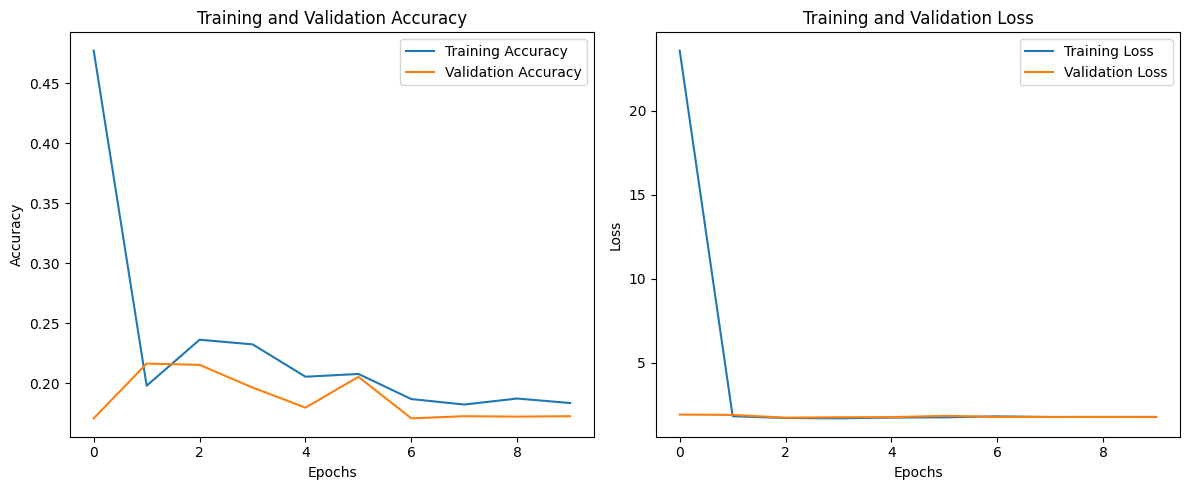

In [34]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Assuming 'model' is already defined and 'dir_train' holds the directory path for training data

# Define batch size and other parameters
batch_size = 32  # Change this value as needed
epochs = 10  # Number of epochs for training

# Load the entire dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dir_train,
    seed=0,
    image_size=(150, 150),
    batch_size=batch_size,
    validation_split=0.2,  # Splitting dataset into training and validation (80-20 split)
    subset="training"  # Indicate to use this portion for training
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dir_train,
    seed=0,
    image_size=(150, 150),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation"  # Indicate to use this portion for validation
)

# Retrieve the number of classes from the dataset
num_classes = len(train_ds.class_names)

# One-hot encode the labels for both training and validation sets
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))

# Compile the model (if not already compiled)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and store training history
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Plotting accuracy and loss per epoch
plt.figure(figsize=(12, 5))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()
